In [ ]:
# Install AutoGluon
# Fast install: https://github.com/autogluon/autogluon/issues/3993

!pip install uv
!uv pip install --system autogluon --no-cache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 126.0 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Resolved 220 packages in 2.64s
Prepared 63 packages in 35.86s
Uninstalled 11 packages in 1.04s
Installed 63 packages in 530ms
 + adagio==0.2.6
 + aiohttp-cors==0.8.1
 + autogluon==1.4.0
 + autogluon-common==1.4.0
 + autogluon-core==1.4.0
 + autogluon-features==1.4.0
 + autogluon-multimodal==1.4.0
 + autogluon-tabular==1.4.0
 + autogluon-timeseries==1.4.0
 + boto3==1.40.66
 + botocore==1.40.66
 + catboost==1.2.8
 + colorama==0.4.6
 + colorful==0.5.8
 + colorlog==6.10.1
 + coreforecast==0.0.16
 + distlib==0.4.0
 + einx==0.3.0
 + evaluate==0.4.6
 + fugue==0.9.2
 + gluonts==0.16.2
 + jmespath==1.0.1
 - jsonschema==4.25.1
 + jsonschema==4.23.0
 + lightning==2.5.5
 + lightning-utilities==0.15.2
 + loguru==0.7.3
 + mlforecast==0.14.0
 + model-index==0.1.11
 + nlpaug==1.1.11
 - nvidia-cudnn-cu12==9.10.2.21
 + nvidia-cudnn-cu12==9.5.1.17
 - nvidia-cusparselt-cu12==0.7.1
 + n

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Import AutoGluon TimeSeries libraries
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# Import libraries for evaluation metrics and plotting
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data file "Exports-by-branches-of-processing-and-countries-2015-2025.parquet"
# This dataset contains export data by branches of processing and countries over time.
url = "https://drive.google.com/uc?export=download&id=1wae6EcQN8VEIp-TeA_kLBPqxq9O4H7xh"
df = pd.read_parquet(url)

In [ ]:
# Pivot the data to a wide format for time series analysis.
# This reshapes the data so that 'Month', 'Country', and 'Branches' form the index,
# and 'Unit' values become columns, with 'DATA' as the values.
df_wide = (
    pd.pivot_table(
        df,
        index=["Month", "Country", "Branches"],
        columns="Unit",
        values="DATA",
        aggfunc="sum",
        dropna=False,
    )
    .reset_index()
)
df_wide.head()

Unit,Month,Country,Branches,Fob value,Quantity,Tonnes
0,2015M01,Afghanistan,"00 Whole fish, fresh, chilled or on ice",0,0,0
1,2015M01,Afghanistan,"01 Fish fillets, fresh, chilled or on ice",0,0,0
2,2015M01,Afghanistan,"02 Other marine products, fresh or chilled",0,0,0
3,2015M01,Afghanistan,"10 Sea frozen fish, whole",0,0,0
4,2015M01,Afghanistan,"11 Sea frozen fish fillets, in blocks",0,0,0


In [ ]:
# Data Wrangling for Time Series Analysis

# Use "Fob value" as the target variable for forecasting.
# Drop the 'Quantity' and 'Tonnes' columns as they are not needed for this task.
df_wide = df_wide[["Month", "Country", "Branches", "Fob value"]]
df_wide = df_wide.rename(columns={"Fob value": "target"})

# Parse the 'Month' column into a datetime format, representing the start of the month.
df_wide["timestamp"] = pd.to_datetime(df_wide["Month"].astype(str).str.replace("M", "-"), format="%Y-%m")
df_wide = df_wide.drop(columns="Month")

# Ensure the target variable is of a numeric type, coercing errors to NaN.
df_wide["target"] = pd.to_numeric(df_wide["target"], errors="coerce")

# Create a unique series ID by combining 'Country' and 'Branches'.
# This is required by AutoGluon to identify individual time series.
df_wide["series_id"] = df_wide["Country"].astype(str) + " • " + df_wide["Branches"].astype(str)

# Sort the data by 'series_id' and 'timestamp' to ensure the correct order for time series.
df_wide = df_wide.sort_values(["series_id", "timestamp"]).reset_index(drop=True)

# Drop time series where the target variable is always zero across the entire history.
# These series do not contain any signal for forecasting.
series_has_signal = df_wide.groupby("series_id")["target"].transform(lambda s: (s != 0).any())
df_wide = df_wide[series_has_signal].copy()

# Keep a separate DataFrame with metadata for later grouping and analysis.
series_meta = df_wide[["series_id", "Country", "Branches"]].drop_duplicates()

print("Rows after cleaning:", len(df_wide))
print("Unique series:", series_meta.shape[0])

Rows after cleaning: 352679
Unique series: 2777


In [ ]:
df_wide.head()

Unit,Country,Branches,target,timestamp,series_id
10033,Albania,49 Agricultural products n.e.s.,0.0,2015-01-01,Albania • 49 Agricultural products n.e.s.
10034,Albania,49 Agricultural products n.e.s.,0.0,2015-02-01,Albania • 49 Agricultural products n.e.s.
10035,Albania,49 Agricultural products n.e.s.,0.0,2015-03-01,Albania • 49 Agricultural products n.e.s.
10036,Albania,49 Agricultural products n.e.s.,0.0,2015-04-01,Albania • 49 Agricultural products n.e.s.
10037,Albania,49 Agricultural products n.e.s.,0.0,2015-05-01,Albania • 49 Agricultural products n.e.s.


In [ ]:
# Define prediction length (number of months to forecast)
prediction_length = 12  # last 12 months as test

# Identify unique months and the test set months
uniq_months = np.sort(df_wide["timestamp"].unique())
test_months = set(uniq_months[-prediction_length:])

# Split the data into training and testing sets based on the identified months
train_df = df_wide[~df_wide["timestamp"].isin(test_months)].copy()
test_df  = df_wide[df_wide["timestamp"].isin(test_months)].copy()

# Define the columns needed for the TimeSeriesDataFrame
cols = ["series_id", "timestamp", "target"]

# Create TimeSeriesDataFrame for training
ts_train = TimeSeriesDataFrame.from_data_frame(
    train_df[cols],
    id_column="series_id",
    timestamp_column="timestamp",
)

# Create TimeSeriesDataFrame for testing
ts_test = TimeSeriesDataFrame.from_data_frame(
    test_df[cols],
    id_column="series_id",
    timestamp_column="timestamp",
)

In [ ]:
# Initialize the TimeSeriesPredictor with the specified prediction length, target variable, frequency, and evaluation metric.
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="target",
    freq="MS", # 'MS' indicates Month Start frequency
    eval_metric="WAPE", # Weighted Absolute Percentage Error
)

# Fit the predictor to the training data.
# presets="medium_quality" trains a diverse set of models for good performance.
# time_limit sets the maximum training time in seconds.
# random_seed ensures reproducibility of the training process.
predictor.fit(
    ts_train,
    presets="medium_quality",
    time_limit=600,
    random_seed=42,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20251105_095057"
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20251105_095057'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       7.36 GB / 12.67 GB (58.1%)
Disk Space Avail:   68.89 GB / 112.64 GB (61.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WAPE,
 'freq': 'MS',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 

In [ ]:
# Shows all models tried, sorted by validation score
leaderboard = predictor.leaderboard(silent=False)

                       model  score_val  pred_time_val  fit_time_marginal  fit_order
0           WeightedEnsemble  -0.451042      24.913393           2.909399          9
1        Chronos[bolt_small]  -0.473544       1.605430           0.055193          7
2  TemporalFusionTransformer  -0.494959       1.399793          49.339034          8
3                        ETS  -0.497902      79.551120           0.059329          5
4                      Theta  -0.506344      15.212396           0.072453          6
5              DirectTabular  -0.522745       0.972055           7.569642          4
6           RecursiveTabular  -0.523702       1.554670          18.527117          3
7                      Naive  -0.563758       4.524319           0.077801          1
8              SeasonalNaive  -0.611463       5.141104           0.079729          2


In [ ]:
# Get information about the trained predictor and the best model.
info = predictor.info()

# Extract the name of the best model and its validation score.
best_model = info["best_model"]
best_score = -info["best_model_score_val"]  # Flip the sign as WAPE is a minimization metric, but AutoGluon stores it as maximization

# Print the best model and its validation score.
print("Best model:", best_model)
print("Best validation WAPE:", best_score)

# Get detailed information about all trained models.
mi = info["model_info"]

# If the best model is a WeightedEnsemble, print details about its base models and their weights.
if best_model == "WeightedEnsemble":
    we = mi["WeightedEnsemble"]
    print("\nEnsemble validation WAPE:", -we["val_score"]) # Flip the sign for WAPE
    print("Base models and weights:")
    for base_name, w in we["model_weights"].items():
        base_rmse = -mi[base_name]["val_score"] # Flip the sign for base model WAPE
        print(f"  - {base_name:22s}  weight={float(w):.4f}  val_RMSE={base_rmse:.3f}")
else:
    # If the best is not an ensemble, print details about the best model.
    bm = mi[best_model]
    print("\nBest model details:")
    print("  type:", bm["model_type"])
    print("  val_RMSE:", -bm["val_score"]) # Flip the sign for WAPE
    print("  fit_time:", bm["fit_time"], "s")
    print("  predict_time:", bm["predict_time"], "s")

Best model: WeightedEnsemble
Best validation WAPE: 0.4510422132944571

Ensemble validation WAPE: 0.4510422132944571
Base models and weights:
  - SeasonalNaive           weight=0.0202  val_RMSE=0.611
  - RecursiveTabular        weight=0.2424  val_RMSE=0.524
  - Theta                   weight=0.1212  val_RMSE=0.506
  - Chronos[bolt_small]     weight=0.4242  val_RMSE=0.474
  - TemporalFusionTransformer  weight=0.1919  val_RMSE=0.495


In [ ]:
# Use the predictor to generate forecasts for the next 'prediction_length' time steps
forecast = predictor.predict(ts_train)

# Work with it directly as a DataFrame
pred = forecast.reset_index()
# Rename 'item_id' to 'series_is' if it exists, for consistency
if "item_id" in pred.columns and "series_id" not in pred.columns:
    pred = pred.rename(columns={"item_id": "series_id"})

# Prepare the truth values from the test set
truth = ts_test.reset_index()
# Rename 'item_id' to 'series_is' if it exists, for consistency
if "item_id" in truth.columns and "series_id" not in truth.columns:
    truth = truth.rename(columns={"item_id": "series_id"})

# Determine the column name for the predicted values (either 'mean' or '0.5' quantile)
yhat_col = "mean" if "mean" in pred.columns else ("0.5" if "0.5" in pred.columns else
               [c for c in pred.columns if c not in {"series_id", "timestamp"}][0])

# Align and merge the predictions, true values, and metadata
# This combines the forecast and actual values for each timer series at each timestamp,
# and includes the original Country and Branches information.
pred = pred[["series_id", "timestamp", yhat_col]].copy()
truth = truth[["series_id", "timestamp", "target"]].copy()

aligned = (
    pred.merge(truth, on=["series_id", "timestamp"], how="inner")
        .merge(series_meta, on="series_id", how="left")
        # Rename the predicted and true value columns for clarity
        .rename(columns={yhat_col: "y_pred", "target": "y_true"})
        # Sort the results for easier analysis
        .sort_values(["series_id", "timestamp"])
        .reset_index(drop=True)
)

# Ensure the true and predicted target variables are of float type
aligned["y_true"] = aligned["y_true"].apply(lambda x: float(x[0]) if isinstance(x, (np.ndarray, list)) else float(x))
aligned["y_pred"] = aligned["y_pred"].apply(lambda x: float(x[0]) if isinstance(x, (np.ndarray, list)) else float(x))
print("Aligned rows:", f"{len(aligned):,}")

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Aligned rows: 33,324


In [ ]:
# Compute overall model metrics
y_true = aligned["y_true"].astype(float).values
y_pred = aligned["y_pred"].astype(float).values

# Basic metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

# Weighted Absolute Percentage Error (WAPE)
# This is a common metric for time series forecasting that is less sensitive to outliers than RMSE.
den = np.sum(np.abs(y_true))
wape = np.nan if den == 0 else np.sum(np.abs(y_true - y_pred)) / den
accuracy = 1 - wape if not np.isnan(wape) else np.nan

# Coefficient of Determination (R²)
# This metric indicates how well the predicted values explain the variance in the true values.
r2 = r2_score(y_true, y_pred)

# --- Print results ---
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"WAPE: {wape:.2%}")
print(f"Accuracy: {accuracy:.2%}")
print(f"R²: {r2:.3f}")

RMSE: 108.02
MAE:  11.93
WAPE: 40.94%
Accuracy: 59.06%
R²: 0.940


Overall WAPE: 40.94%
Overall R²:   0.940

Top 10 branches (by WAPE):


,Branches,WAPE,R2,Accuracy
0,"01 Fish fillets, fresh, chilled or on ice",0.139664,0.972118,0.860336
1,28 Dried fish heads,0.209152,0.938965,0.790848
2,71 Products of power intensive plants,0.230358,0.955588,0.769642
3,"00 Whole fish, fresh, chilled or on ice",0.358552,0.856947,0.641448
4,"89 Other manufacturing, n.e.s.",0.376067,0.879413,0.623933
5,21 Uncured salted fish,0.393287,0.843293,0.606713
6,16 Frozen fish fillets n.e.s.,0.449949,0.781371,0.550051
7,"29 Other dried, salted fish",0.457765,0.819581,0.542235
8,"12 Sea frozen fish fillets, n.e.s.",0.474243,0.742243,0.525757
9,41 Farmed fish,0.491656,0.685292,0.508344


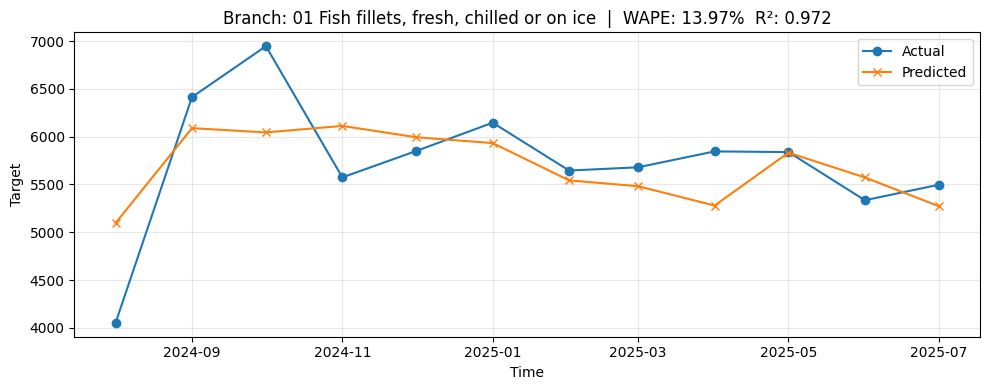

In [ ]:
# Create a copy of the aligned DataFrame to work with
aligned = pd.DataFrame(aligned).copy()

# Define custom evaluation metrics functions
# Weighted Absolute Percentage Error (WAPE)
def wape(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    denom = np.sum(np.abs(y_true))
    return np.nan if denom == 0 else np.sum(np.abs(y_true - y_pred)) / denom

# Safe R-squared calculation (handles cases with only one data point)
def r2_safe(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan

# Calculate and print overall metrics
overall_wape = wape(aligned["y_true"], aligned["y_pred"])
overall_r2   = r2_safe(aligned["y_true"], aligned["y_pred"])
print(f"Overall WAPE: {overall_wape:.2%}")
print(f"Overall R²:   {overall_r2:.3f}")

# Calculate and print metrics grouped by 'Branches'
# This helps in understanding the model's performance on different categories
by_branch = (
    aligned.groupby("Branches", dropna=False)
          .apply(lambda g: pd.Series({
               "WAPE": wape(g["y_true"], g["y_pred"]),
               "R2":   r2_safe(g["y_true"], g["y_pred"]),
          }),
          include_groups=False
    )
    .reset_index()
)
# Calculate Accuracy from WAPE
by_branch["Accuracy"] = 1 - by_branch["WAPE"]
# Sort by WAPE to see the best performing branches first
by_branch = by_branch.sort_values("WAPE").reset_index(drop=True)

print("\nTop 10 branches (by WAPE):")
# Display the top 10 branches with their calculated metrics
display(by_branch.head(10))

# Plot an example time series for the best performing branch
# Get the name of the best branch
best = by_branch.iloc[0]["Branches"]
# Filter the aligned data for the best branch
sub = aligned[aligned["Branches"] == best].copy()
# Sort the data by timestamp
sub = sub.sort_values("timestamp")
# Group by timestamp and sum the true and predicted values
sub = sub.groupby("timestamp")[["y_true", "y_pred"]].sum().reset_index()

# Create the plot
plt.figure(figsize=(10,4))
# Plot the actual values
plt.plot(sub["timestamp"], sub["y_true"], marker="o", label="Actual")
# Plot the predicted values
plt.plot(sub["timestamp"], sub["y_pred"], marker="x", label="Predicted")
# Set the title of the plot with the branch name and its WAPE and R² scores
plt.title(f"Branch: {best}  |  WAPE: {by_branch.loc[by_branch['Branches']==best,'WAPE'].values[0]:.2%}  "
          f"R²: {by_branch.loc[by_branch['Branches']==best,'R2'].values[0]:.3f}")
# Set labels for the axes
plt.xlabel("Time"); plt.ylabel("Target")
# Add a legend to the plot
plt.legend();
# Add a grid for better readability
plt.grid(alpha=0.3);
# Adjust layout to prevent labels overlapping
plt.tight_layout()
# Display the plot
plt.show()